In [32]:
!pip install -U -q kaggle --force

ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [33]:
from google.colab import files
f=files.upload()

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [37]:
!kaggle competitions download -c nnfl-cnn-lab2

nnfl-cnn-lab2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [38]:
%%bash
cd /content
unzip nnfl-cnn-lab2.zip

Archive:  nnfl-cnn-lab2.zip


replace upload/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [0]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [40]:
import numpy as np
import pandas as pd 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
print(os.listdir("../content"))


['.config', 'upload', 'nnfl-cnn-lab2.zip', 'kaggle.json', 'sample_data']


##Training Data



In [0]:
df = pd.read_csv("../content/upload/train_set.csv", sep=",")

In [42]:
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [0]:
# df.info()

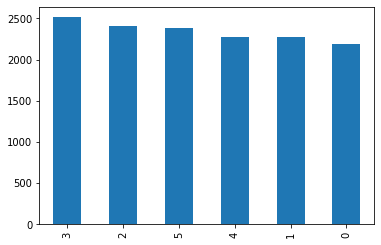

In [44]:
df['label'].value_counts().plot.bar()

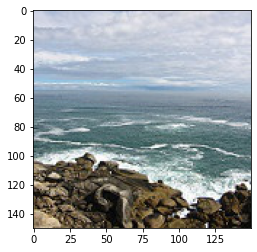

In [45]:
image = load_img("../content/upload/train_images/train_images/7.jpg")
plt.imshow(image)


## Prepare Data


In [46]:
df['label'].head()

0    0
1    4
2    5
3    0
4    4
Name: label, dtype: int64

In [47]:
df['label']=df['label'].astype(str)
df['label'].head()

0    0
1    4
2    5
3    0
4    4
Name: label, dtype: object

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

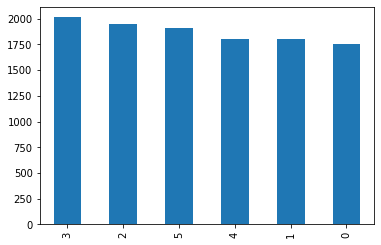

In [49]:
train_df['label'].value_counts().plot.bar()

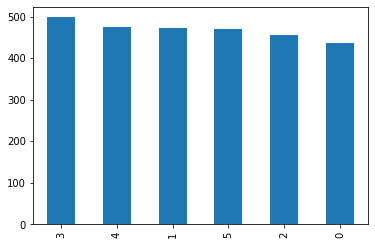

In [50]:
validate_df['label'].value_counts().plot.bar()

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [52]:
print(total_train)
print(total_validate)

11227
2807


In [53]:
train_df.head()

,image_name,label
0,11372.jpg,1
1,16518.jpg,3
2,7061.jpg,3
3,16430.jpg,2
4,12370.jpg,1


##Preparing Testing Data

In [0]:
test_filenames = os.listdir("../content/upload/test_images/test_images/")
test_df = pd.DataFrame({
    'image_name': test_filenames
})
nb_samples = test_df.shape[0]

In [55]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../content/upload/test_images/test_images/", 
    x_col='image_name',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 7301 validated image filenames.


##Training Generator

In [56]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../content/upload/train_images/train_images/", 
    x_col='image_name',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 11227 validated image filenames belonging to 6 classes.


Validation Generator

In [57]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../content/upload/train_images/train_images/", 
    x_col='image_name',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2807 validated image filenames belonging to 6 classes.


#Model

In [58]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

In [0]:
earlystop = EarlyStopping(patience=10)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
callbacks = [earlystop, learning_rate_reduction]

#Fit Model

In [31]:
epochs=10 if FAST_RUN else 20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
168/748 [=====>........................] - ETA: 38s - loss: 1.6821 - accuracy: 0.4310

KeyboardInterrupt: ignored

##Saving Model

In [0]:
model.save_weights("model_try.h5")

##Graphs loss

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

##Predict

In [0]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [0]:
test_df['label'] = np.argmax(predict, axis=-1)

In [0]:
test_df['label'].value_counts().plot.bar()

Seeing predicted results with Images


In [0]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['image_name']
    category = row['label']
    img = load_img("../content/upload/test_images/test_images/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

##Submission CSV

In [0]:
test_df.head()

In [0]:
submission_df = test_df.copy()
#submission_df.drop(['image_name', 'label'], axis=1, inplace=True)
submission_df.to_csv('submission_try.csv', index=False)

In [0]:
submission_df.head()

In [0]:
# from google.colab import files
# files.download("../content/model_try.h5")
# files.download("../content/submission_try.csv")